<h1 align="center"><b>Interpreting CNN Predictions in Malaria Cell Classification using LIME</b></h1>

<h3 align="center">Developing a Locally Interpretable Model to Demystify CNN Decision-Making in Malaria Image Classification</h3>


---
---
## Table of Contents

1. [Introduction](#Introduction)
2. [Loading Pre-Trained Malaria-CNN-Classifier Model](#Loading-Pre-Trained-Malaria-CNN-Classifier-Model)
3. [Loading and Preprocessing One Classified Image by CNN](#Loading-and-Preprocessing-One-Classified-Image-by-CNN)
4. [Verifying the Model's Prediction on the Selected Image](#Verifying-the-Model's-Prediction-on-the-Selected-Image)
5. [Explaining Predictions with LIME](#Explaining-Predictions-with-LIME)
   - 5.1 [Generating Perturbations in the Image](#Step-1:-Generating-Perturbations-in-the-Image)
      - 5.1.1 [Superpixel Segmentation Using Quickshift Algorithm](#1.1.-Superpixel-Segmentation-Using-Quickshift-Algorithm)
      - 5.1.2 [Generating Random Perturbations](#1.2.-Generating-Random-Perturbations)
      - 5.1.3 [Apply the Perturbation to the Image and Display](#1.3.-Apply-the-Perturbation-to-the-Image-and-Display)
   - 5.2 [Predicting Outcomes for Perturbed Images with the CNN Malaria Classifier](#Step-2:-Predicting-Outcomes-for-Perturbed-Images-with-the-CNN-Malaria-Classifier)
   - 5.3 [Calculating Distances and Assigning Weights to Perturbations](#Step-3:-Calculating-Distances-and-Assigning-Weights-to-Perturbations)
      - 5.3.1 [Computing Cosine Distances Between Perturbations and the Original Image](#3.1.-Computing-Cosine-Distances-Between-Perturbations-and-the-Original-Image)
      - 5.3.2 [Applying a Kernel Function to Compute Weights](#3.2.-Applying-a-Kernel-Function-to-Compute-Weights)
   - 5.4 [Constructing an Interpretable Linear Model](#Step-4:-Constructing-an-Interpretable-Linear-Model)
      - 5.4.1 [Constructing-the-Explainable-Model](#4.1.-Constructing-the-Explainable-Model)
   - 5.5 [Extracting Insights from the Linear Model](#Step-5:-Extracting-Insights-from-the-Linear-Model)
      - 5.5.1 [Isolating Influential Superpixels](#5.1.-Isolating-Influential-Superpixels)
      - 5.5.2 [Visualizing the LIME Explanation: Highlighting Key Features](#5.2.-Visualizing-the-LIME-Explanation:-Highlighting-Key-Features)


---
---

## Introduction

In this analytical notebook, we delve into the intriguing domain of model interpretability, utilizing the **Local Interpretable Model-agnostic Explanations (LIME)** framework. This approach is inspired by the pioneering work of Ribeiro et al. (2016), as presented in their insightful paper ([Ribeiro et. al. 2016](https://arxiv.org/abs/1602.04938)). **LIME** stands out as a robust tool for demystifying the decision-making processes of complex machine learning models.

Our primary objective is to explore the '**why**' behind the predictions of our CNN model. By implementing **LIME**, we aim to uncover specific features and patterns within malaria cell images that influence the classifier's decision-making, particularly in distinguishing between '**infected**' and '**uninfected**' cells. This exploration not only aids in validating our model's performance but also enhances our understanding of its predictive behavior, thereby contributing to more transparent and trustworthy AI solutions in medical diagnostics.

---
---

## Loading Pre-Trained Malaria-CNN-Classifier Model

In [ ]:
# Extend system path to include 'Scripts' and 'Utilities' directories for module imports
import sys
sys.path.extend(['../Scripts', '../Utilities'])

# Import required libraries
from import_libraries import get_data_handling_and_viz_libs, get_lime_related_libs

np, plt, sns, cv2 = get_data_handling_and_viz_libs()
skimage, sklearn, LinearRegression, warnings, load_model = get_lime_related_libs()

np.random.seed(222)

In [2]:
# Path to the saved model
pretrained_model_path = '/Models/best_CNN_for_Malaria_classifier.keras'

# Load the pre-trained model
pretrained_cnn = load_model(pretrained_model_path)

# Display the model's architecture
pretrained_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                             

---
---

## Loading and Preprocessing One Classified Image by CNN

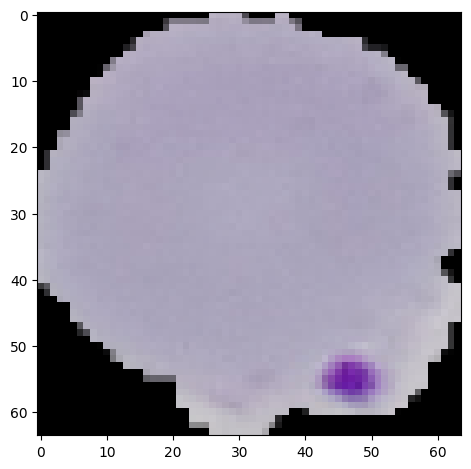

In [20]:
# Loading an Image Classified as 'Infected' by the Malaria Classifier
image = skimage.io.imread("/Images/predicted_sample2.png")

image = image.astype('float32') / 255.

# Display the image
skimage.io.imshow(image)

---
---
## Verifying the Model's Prediction on the Selected Image

In this section, we'll re-evaluate the classification of the image that was previously loaded to confirm its predicted label. Our binary classification model outputs a probability vector with two elements, each representing the likelihood of the image belonging to one of the two classes in the **Malaria Cell Dataset**. This step not only verifies the model's prediction but also provides insight into the confidence levels associated with each classification decision.


In [4]:
# Predict the class of the selected image by pre-trained CNN model
probability_vector = pretrained_cnn.predict(image[np.newaxis, :, :, :])
print("Predicted Classes:", probability_vector)

1/1 [==============================] - 0s 118ms/step
Predicted Classes: [[9.9998319e-01 1.6866348e-05]]


In [6]:
# This snippet selects the top two predictions and is adaptable for multi-class scenarios
top_pred_classes = probability_vector[0].argsort()[-2:][::-1]
print("Top predicted classes: ", top_pred_classes)      

Top predicted classes:  [0 1]


In [5]:
# Define the class labels for the binary classification task: {0: "Infected", 1: "Uninfected"}
class_labels = [0, 1] 

# Use np.argmax to find the index of the maximum value in the predictions array.
# This index corresponds to the most likely class predicted by the model.
predicted_class_indices = np.argmax(probability_vector, axis=1)

# Map the predicted index to its corresponding class label.
# This step converts the index to an actual class name or number.
predicted_classes = [class_labels[i] for i in predicted_class_indices]

# Since we only have one image, we access the first element of the predicted_classes list.
print("Predicted Class for the Image:", predicted_classes[0])

Predicted Class for the Image: 0


---
---

## Explaining Predictions with LIME

LIME, or Local Interpretable Model-agnostic Explanations, is a technique developed to demystify the decision-making processes of complex machine learning models. It offers a window into the often opaque 'black box' of models like CNNs by providing interpretable explanations for individual predictions. LIME achieves this by locally approximating the complex model with a simpler, more understandable model. It then uses the characteristics of this simpler model to elucidate how certain features influence the prediction outcome.

---

### Step 1: Generating Perturbations in the Image

In LIME, creating perturbations involves selectively activating or deactivating superpixels in an image. Superpixels are clusters of pixels sharing similar attributes, like color or texture, and represent larger, coherent segments of the image. 

**Note:** Deactivating a superpixel, often referred to as "turning it off," typically means modifying it to become non-informative. This is usually achieved by changing all its pixels to a constant color (e.g., gray), effectively masking that portion of the image and rendering it neutral in the analysis.


#### 1.1. Superpixel Segmentation Using Quickshift Algorithm

For the initial phase of creating perturbations, we use the quickshift segmentation algorithm to divide the image into superpixels. Quickshift is a popular method for image segmentation, efficiently grouping pixels into larger, coherent regions based on color similarity and proximity. These superpixels form the basis for generating perturbations, as they are the elements we'll selectively 'turn on' or 'off' in the subsequent steps.


Number of Superpixels Generated: 89


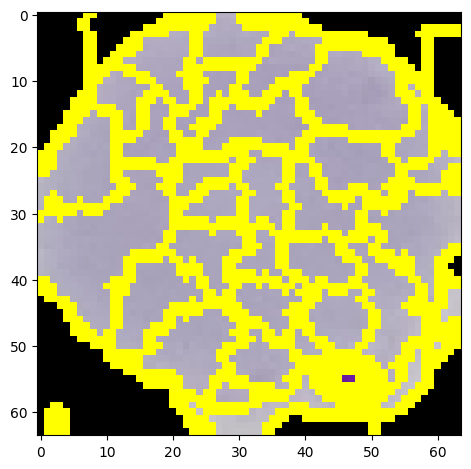

In [7]:
# Create superpixels
superpixels = skimage.segmentation.quickshift(image, kernel_size=1, max_dist=10, ratio=1.0, channel_axis=-1)

# Count the number of unique superpixels
num_superpixels = np.unique(superpixels).shape[0]

print(f"Number of Superpixels Generated: {num_superpixels}")

# Mark the boundaries of the superpixels on the image
superpixel_boundaries_image = skimage.segmentation.mark_boundaries(image, superpixels)

# Display the image with superpixel boundaries
skimage.io.imshow(superpixel_boundaries_image)

#### 1.2. Generating Random Perturbations

To explore how different regions (superpixels) of the image influence the model's prediction, we generate a series of random perturbations. Each perturbation is a unique combination of superpixels being active ("on") or inactive ("off"). An active superpixel is left unchanged, whereas an inactive one is masked or altered. This approach allows us to assess the impact of specific image regions on the classifier's decision-making process.

In [8]:
# Define the number of perturbations
num_perturbations = 150  

# Generate random perturbations
# Each row represents a perturbation and each column corresponds to a superpixel
random_perturbations = np.random.binomial(1, 0.5, size=(num_perturbations, num_superpixels))

# Display the first perturbation as an example
# Each element in this array corresponds to a superpixel in the image.
# '1' indicates that the corresponding superpixel is "on" (active or unchanged), and '0' indicates that the superpixel is "off" (inactive or masked/altered).
print("Example Perturbation:", random_perturbations[149])

Example Perturbation: [1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 0
 1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 1 1
 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0]


####  1.3. Apply the Perturbation to the Image and Display

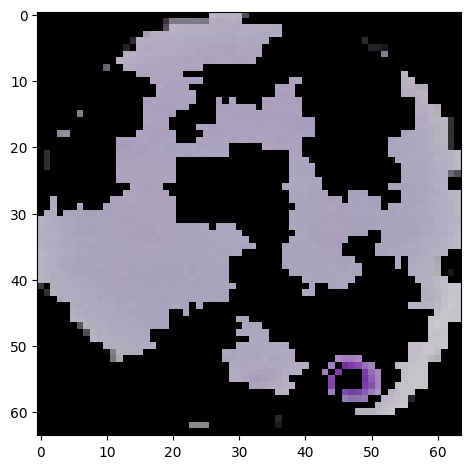

In [21]:
import copy

def apply_perturbation_to_image(image, perturbation, segments):
    """
    Apply a perturbation to an image.

    Parameters:
    - image: The original image in normalized form.
    - random_perturbations: A vector indicating which superpixels to turn on (1) or off (0).
    - quickshift_segments: The superpixel segmentation of the image.

    Returns:
    - A perturbed version of the image.
    """
    # Identify active superpixels from the perturbation vector
    active_superpixels = np.where(perturbation == 1)[0]

    # Initialize a mask to apply perturbations
    perturbation_mask = np.zeros(segments.shape)

    # Activate the superpixels in the mask according to the perturbation vector
    for active in active_superpixels:
        perturbation_mask[segments == active] = 1

    # Apply the perturbation mask to the image
    perturbed_image = copy.deepcopy(image)

    perturbed_image *= perturbation_mask[:, :, np.newaxis]

    return perturbed_image


# Apply the first perturbation from our matrix to the image
perturbed_example_image = apply_perturbation_to_image(image, random_perturbations[0], superpixels)

# Display the perturbed image
skimage.io.imshow(perturbed_example_image)

---

### Step 2: Predicting Outcomes for Perturbed Images with the CNN Malaria Classifier

In this step, the CNN Malaria Classifier is used to predict outcomes for each perturbed image. By analyzing how these perturbations influence the classifier's predictions, we gain insights into the model's decision-making process. This approach helps us understand the relative importance of different image regions (superpixels) in the model's classification of an image as 'infected' or 'uninfected'.

In [22]:
# Initialize a list to store the predictions for each perturbed image
perturbation_predictions = []

# Iterate over each perturbation
for perturbation in random_perturbations:
    # Apply the current perturbation to the image
    perturbed_img = apply_perturbation_to_image(image, perturbation, superpixels)

    # Predict the class probabilities using the pretrained CNN model
    model_prediction = pretrained_cnn.predict(perturbed_img[np.newaxis, :, :, :])
    perturbation_predictions.append(model_prediction)

# Convert the list of predictions into a numpy array for further analysis
perturbation_predictions = np.array(perturbation_predictions)

1/1 [==============================] - 0s 10ms/step


---

### Step 3: Calculating Distances and Assigning Weights to Perturbations

This step involves quantifying the impact of each perturbation on the classifier's decision-making. We achieve this by calculating the distance between the original image and each of its perturbed versions. Perturbations more similar (closer) to the original image are assigned higher weights, indicating their greater relevance in influencing the classifier’s decision. This weighting reflects the premise that perturbations closely resembling the original image are more informative for understanding the model's behavior.

#### 3.1. Computing Cosine Distances Between Perturbations and the Original Image

To assess the deviation of each perturbation from the original image, I employ the cosine distance metric. This approach quantifies the degree of change introduced by each perturbation, providing a basis for understanding their relative impact on the classifier’s predictions. Cosine distance effectively measures the angular difference between the original and perturbed images, making it a suitable choice for this analysis.


In [23]:
# Represent the original image as a perturbation where all superpixels are enabled
original_image_rep = np.ones(num_superpixels)[np.newaxis, :]

# Calculate cosine distances between each perturbation and the original image representation
cosine_distances = sklearn.metrics.pairwise_distances(random_perturbations, original_image_rep, metric='cosine').ravel()
print("Shape of Cosine Distances Array:", cosine_distances.shape)


Shape of Cosine Distances Array: (150,)


#### 3.2. Applying a Kernel Function to Compute Weights

Following the calculation of cosine distances, these values are then transformed into weights using a kernel function. The choice of kernel width is pivotal here; it defines the extent of the 'locality' considered around our original instance. In the case of cosine distances, which generally vary from 0 to 1, opting for a moderate kernel width is typically effective. This kernel function essentially determines how much influence each perturbed instance has based on its proximity to the original image, with closer instances (smaller distances) receiving higher weights.

In [24]:
# Define the kernel width
kernel_width = 0.9 

# Apply the kernel function to convert distances into weights
weights = np.sqrt(np.exp(-(cosine_distances ** 2) / kernel_width ** 2))
print("Shape of Weights Array:", weights.shape)

Shape of Weights Array: (150,)


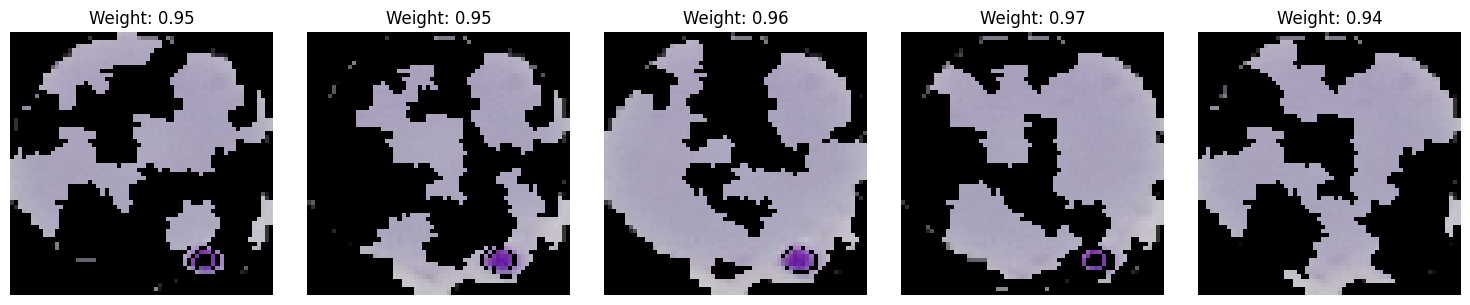

In [15]:
def visualize_perturbations_with_weights(original_image, perturbations, weights, segments, num_samples=5):
    """
    Visualizes a selection of perturbed images with their corresponding weights.

    Parameters:
    - original_image: The original image.
    - perturbations: The matrix of perturbations.
    - weights: The array of weights corresponding to each perturbation.
    - segments: The superpixel segmentation of the original image.
    - num_samples: Number of perturbed images to visualize.
    """
    sample_indices = np.random.choice(perturbations.shape[0], num_samples, replace=False)

    plt.figure(figsize=(15, 3))

    for i, index in enumerate(sample_indices):
        perturbation = perturbations[index]
        weight = weights[index]

        # Create perturbed image
        active_pixels = np.where(perturbation == 1)[0]
        perturbed_image = copy.deepcopy(original_image)
        for segment_val in np.unique(segments):
            if segment_val in active_pixels:
                perturbed_image[segments == segment_val] = original_image[segments == segment_val]
            else:
                perturbed_image[segments == segment_val] = [0, 0, 0]  # Turning off the superpixel

        # Display the perturbed image
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(perturbed_image)
        plt.title(f'Weight: {weight:.2f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example Usage
visualize_perturbations_with_weights(image, random_perturbations, weights, superpixels, num_samples=5)


---
### Step 4: Constructing an Interpretable Linear Model

The aim of this step is to simplify the complex decision-making of the CNN model using a more interpretable approach. To do this, a weighted linear regression model is fitted. This model takes the perturbations as inputs and the CNN model's predictions as outputs, with the significance of each perturbation (as determined earlier) factored in as weights. Through this process, the linear model serves as a transparent approximation of the CNN, highlighting which features (superpixels) most influence the classification outcome.


#### 4.1. Constructing the Explainable Model

The goal here is to dissect how each superpixel in the image influences the prediction of a specific class. Specifically, we'll focus on explaining the model's prediction for the class deemed most likely by the CNN. This approach will provide a detailed insight into which segments of the image (superpixels) are pivotal in guiding the classifier's decision for this particular class.

In [25]:
# Identify the class to explain based on the predicted label
target_class = top_pred_classes[0]

# Initialize a linear regression model as an explainable model
explainable_model = LinearRegression()

# Fit the model using the perturbations as features, the predictions for the class to explain as the target,
# and the weights as sample weights to emphasize important perturbations
explainable_model.fit(X=random_perturbations, y=perturbation_predictions[:,:,target_class], sample_weight=weights)

# Extract the coefficients of the linear model
# Each coefficient corresponds to the influence of a superpixel
importance_coefficients = explainable_model.coef_[0]

# Print the coefficients to understand the importance of each superpixel
print("Superpixel Importance Coefficients:", importance_coefficients)


Superpixel Importance Coefficients: [ 0.01122533 -0.04065817  0.04941215  0.03581746 -0.06572397 -0.04914387
 -0.02067309  0.07064952  0.01874372 -0.0214202   0.03823409 -0.03486525
  0.01391353  0.00981889 -0.02112661  0.00331193 -0.06283544 -0.04544322
 -0.00048707  0.03755395  0.07546116  0.04808492 -0.05780887 -0.03548274
  0.00697307  0.01796999  0.0228202  -0.00570348 -0.00328914 -0.01935521
 -0.01615624  0.03090794 -0.0084569  -0.03845731  0.01920723  0.04038228
 -0.02502178 -0.09231326  0.00752388  0.00085497  0.00932667 -0.06847315
 -0.07592063  0.06039958 -0.01404342 -0.01231678  0.02209104 -0.01106526
 -0.02503289 -0.03050027 -0.04209394 -0.01326412  0.09246757  0.0246864
  0.04536229  0.02493507  0.06580762  0.0646476   0.11696967  0.04176777
 -0.00193512  0.05366553 -0.02147041 -0.03768662  0.01912089  0.01293617
 -0.0201028  -0.08186993  0.05568727  0.0516112   0.26945774  0.11415031
 -0.010587    0.02309339  0.45291943  0.0441952   0.00354108  0.04678318
  0.00966238  0.

---

### Step 5: Extracting Insights from the Linear Model

In this essential final phase of our LIME analysis, we turn our attention to interpreting the outcomes offered by our simpler, interpretable linear model. The focus here is on pinpointing the superpixels — distinct features within our image — that hold significant sway over the model's predictions.

Through this process, we aim to unravel the complexities of our CNN model's decision-making. By identifying and understanding the impact of each superpixel, we can gain valuable insights into what drives the model's classifications, shedding light on the 'why' behind its predictions.

#### 5.1. Isolating Influential Superpixels

A pivotal aspect of our interpretative journey involves delving into the coefficients derived from our linear model. These coefficients are more than mere numbers; they represent the degree of influence each superpixel wields over the model's prediction. By meticulously sorting these coefficients, we embark on a quest to unveil the superpixels that play a dominant role in driving the classification decision. This exploration is instrumental in unearthing the critical elements within the image that our model perceives as decisive in distinguishing one class from another.


In [32]:
# Define the number of top features (superpixels) to consider
number_of_top_features = 2  

# Sort the coefficients to identify the superpixels with the highest influence
# The sorting is based on the absolute magnitude of the coefficients
top_influential_features = np.argsort(importance_coefficients)[-number_of_top_features:]

print("Top Influential Superpixels:", top_influential_features)

Top Influential Superpixels: [70 74]


#### 5.2. Visualizing the LIME Explanation: Highlighting Key Features

In this enlightening phase, we endeavor to visually manifest the most influential superpixels, as discerned in the preceding analysis. This involves crafting a compelling image where the pivotal superpixels are prominently featured, while the less consequential ones are subtly obscured. The result is a visual narrative that not only encapsulates the essence of our model's reasoning but also illuminates the specific image segments that pivotally sway its decision-making process.


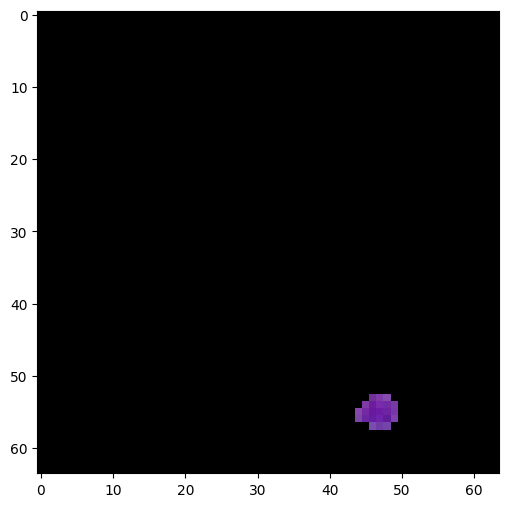

In [33]:
mask = np.zeros(num_superpixels)
mask[top_influential_features]= True #Activate top superpixels

# Apply the perturbation mask
perturbed_image = apply_perturbation_to_image(image, mask, superpixels)

# Display the image using matplotlib
plt.figure(figsize=(6, 6))  
plt.imshow(perturbed_image)
plt.axis('on') 
plt.show()